# Метрики качества бинарной классификации

## Задача об фальшивых банкнотах

In [74]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [75]:
import os
import requests


url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt'

if not os.path.exists('data_banknote_authentication.txt'):
    r = requests.get(url, allow_redirects=True)

    with open('data_banknote_authentication.txt', 'wb') as fd:
        fd.write(r.content)

In [76]:
import pandas as pd

col_names = [
    'variance',
    'skewness',
    'curtosis',
    'entropy',
    'class',
]

ds = pd.read_csv('data_banknote_authentication.txt', names=col_names)
ds.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


## Дисбаланс классов

In [131]:
ds['class'].value_counts()

0    762
1    610
Name: class, dtype: int64

In [181]:
ds_0 = ds[ds['class'] == 0]
ds_1 = ds[ds['class'] == 1]

ds_1_subsamle = ds_1.sample(100)

ds_imbalanced = pd.concat((ds_0, ds_1_subsamle), axis=0)
ds_imbalanced['class'].value_counts()

0    762
1    100
Name: class, dtype: int64

In [182]:
X = ds_imbalanced[col_names[0:2]].values
y = ds_imbalanced['class'].values

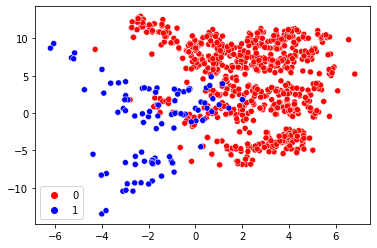

In [183]:
import seaborn as sns

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette=['red', 'blue']);

In [184]:
RANDOM_SEED = 42

## Обучающая и проверочная выборки

In [185]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=RANDOM_SEED,
)

## Сравнение различных классификаторов

В том случае, когда у сравниваемых классификаторов различные функции потерь, то сравнение по абсолютным значениям функций потерь не имеет смысла. В этом случае необходимо привести различные классификаторы к общей метрике качества.

## Логистическая регрессия

In [186]:
from sklearn.linear_model import LogisticRegression

logreg_clf = LogisticRegression(random_state=RANDOM_SEED).fit(X_train, y_train)

## kNN

In [198]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)

## Доля правильных ответов

In [199]:
from sklearn.metrics import accuracy_score

logreg_y_pred = logreg_clf.predict(X_test)
logreg_acc = accuracy_score(y_test, logreg_y_pred)

knn_y_pred = knn_clf.predict(X_test)
knn_acc = accuracy_score(y_test, knn_y_pred)

print("LogReg accuracy = {:.4f}".format(logreg_acc))
print("kNN accuracy = {:.4f}".format(knn_acc))

LogReg accuracy = 0.9537
kNN accuracy = 0.9575


## Матрица ошибок

![title](https://miro.medium.com/max/332/1*BTB9weIUfSsSRy5kvh_-uA.png)

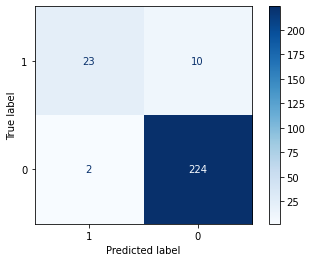

In [200]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(logreg_clf, X_test, y_test, cmap=plt.cm.Blues, labels=[1, 0]);

## Точность и полнота

**Точность** (Precision) - Доля правильных ответов, среди всех _предсказаний_ позитивного класса
$$
P = \frac{TP}{TP + FP}
$$

**Полнота** (Recall) - доля правильных ответов среди всех _истинных_ примеров позитивного класса
$$
R = \frac{TP}{TP + FN}
$$

In [201]:
from sklearn.metrics import precision_score, recall_score

logreg_precision = precision_score(y_test, logreg_y_pred)
logreg_recall = recall_score(y_test, logreg_y_pred)

knn_precision = precision_score(y_test, knn_y_pred)
knn_recall = recall_score(y_test, knn_y_pred)

print("LogReg precision = {:.4f}".format(logreg_precision))
print("LogReg recall = {:.4f}".format(logreg_recall))
print("")
print("kNN precision = {:.4f}".format(knn_precision))
print("kNN recall = {:.4f}".format(knn_recall))

LogReg precision = 0.9200
LogReg recall = 0.6970

kNN precision = 0.8929
kNN recall = 0.7576


## F мера

$F_1$ мера - гармоническое среднее между точностью и полнотой
$$
F_1 = \frac{2PR}{P+R}.
$$

$F_\beta$ - обобщенние $F$-меры, использующая коэффициент $\beta$ - степень важности полноты по сравнению с точностью. 
$$
F_\beta = (1+\beta^2)\frac{PR}{\beta^2 P + R} = \frac{(1+\beta^2)TP}{(1+\beta^2)TP + \beta^2 FN + FP}.
$$

In [202]:
from sklearn.metrics import f1_score

logreg_f1 = f1_score(y_test, logreg_y_pred)
knn_f1 = f1_score(y_test, knn_y_pred)

print("LogReg F1 = {:.4f}".format(logreg_f1))
print("kNN F1 = {:.4f}".format(knn_f1))

LogReg F1 = 0.7931
kNN F1 = 0.8197


## PR - кривая

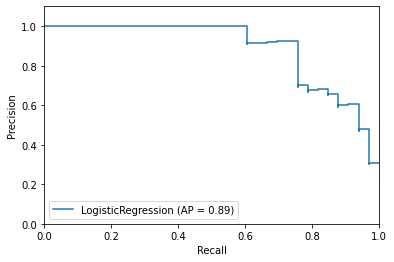

In [209]:
from sklearn.metrics import plot_precision_recall_curve

logreg_y_proba = logreg_clf.predict_proba(X_test)[:, 1]

disp = plot_precision_recall_curve(logreg_clf, X_test, y_test)
disp.ax_.set_ylim((0, 1.1))
disp.ax_.set_xlim((0, 1));

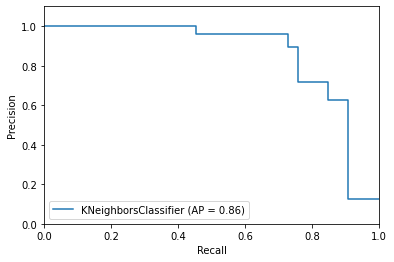

In [213]:
disp = plot_precision_recall_curve(knn_clf, X_test, y_test)
disp.ax_.set_ylim((0, 1.1))
disp.ax_.set_xlim((0, 1));

## ROC-кривая

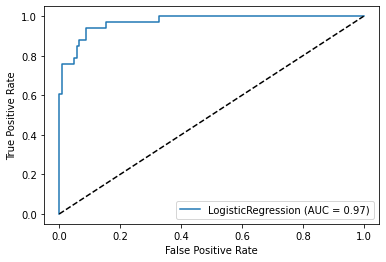

In [225]:
from sklearn.metrics import plot_roc_curve

disp = plot_roc_curve(logreg_clf, X_test, y_test)
disp.ax_.plot([0, 1], [0, 1], 'k--');

## Источники
1. Banknote authentication Data Set, url - http://archive.ics.uci.edu/ml/datasets/banknote+authentication